### Import Library

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import xgboost as xgb
from sklearn.metrics import f1_score, precision_recall_curve
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split

### EDA

In [18]:
# Load data
train_data = pd.read_csv('/kaggle/input/cci-summit/train.csv')
test_data = pd.read_csv('/kaggle/input/cci-summit/test.csv')

In [29]:
train_data.head()

,ID,Kelas Pekerjaan,fnlwgt,Pendidikan,Jenjang Pendidikan,Status,Pekerjaan,Hubungan,Etnis,sex,pendapatan,pengeluaran,hours per week,Asal Negara,jumlah_anak,income,age
0,478,Swasta,37210,Sarjana,Sarjana,Menikah,Eksekutif Manager,Suami,1,Male,0,0,45,United-States,2,1,32
1,479,Swasta,101950,Magister,Magister,Belum-menikah,Eksekutif Manager,Tidak dalam Keluarga,1,Female,0,0,45,United-States,0,0,43
2,480,NaN,122244,SMA Grad,SMA Grad,Belum-menikah,NaN,Tidak dalam Keluarga,1,Female,0,0,28,United-States,0,0,20
3,481,Pemerintah daerah,24763,Diploma,Kuliah,Cerai,Transportasi dan Pengangkutan,Belum Menikah,1,Male,6849,0,40,United-States,0,0,40
4,482,Swasta,113936,Sarjana,Sarjana,Belum-menikah,Spesialis Profesional,Punya Anak,1,Male,0,0,40,United-States,0,0,24


In [30]:
train_data.shape

(26069, 17)

Dataset memiliki 26096 baris dan 17 kolom

In [31]:
# Cek nilai NULL
print(train_data.isnull().sum())
print(test_data.isnull().sum())

ID                       0
Kelas Pekerjaan       1475
fnlwgt                   0
Pendidikan               0
Jenjang Pendidikan       0
Status                   0
Pekerjaan             1481
Hubungan                 0
Etnis                    0
sex                      0
pendapatan               0
pengeluaran              0
hours per week           0
Asal Negara              0
jumlah_anak              0
income                   0
age                      0
dtype: int64
ID                      0
Kelas Pekerjaan       363
fnlwgt                  0
Pendidikan              0
Jenjang Pendidikan      0
Status                  0
Pekerjaan             364
Hubungan                0
Etnis                   0
sex                     0
pendapatan              0
pengeluaran             0
hours per week          0
Asal Negara             0
jumlah_anak             0
age                     0
dtype: int64


Terdapat dua kelas yang memiliki nilai null baik dai data train maupun data test

income
0    19790
1     6279
Name: count, dtype: int64

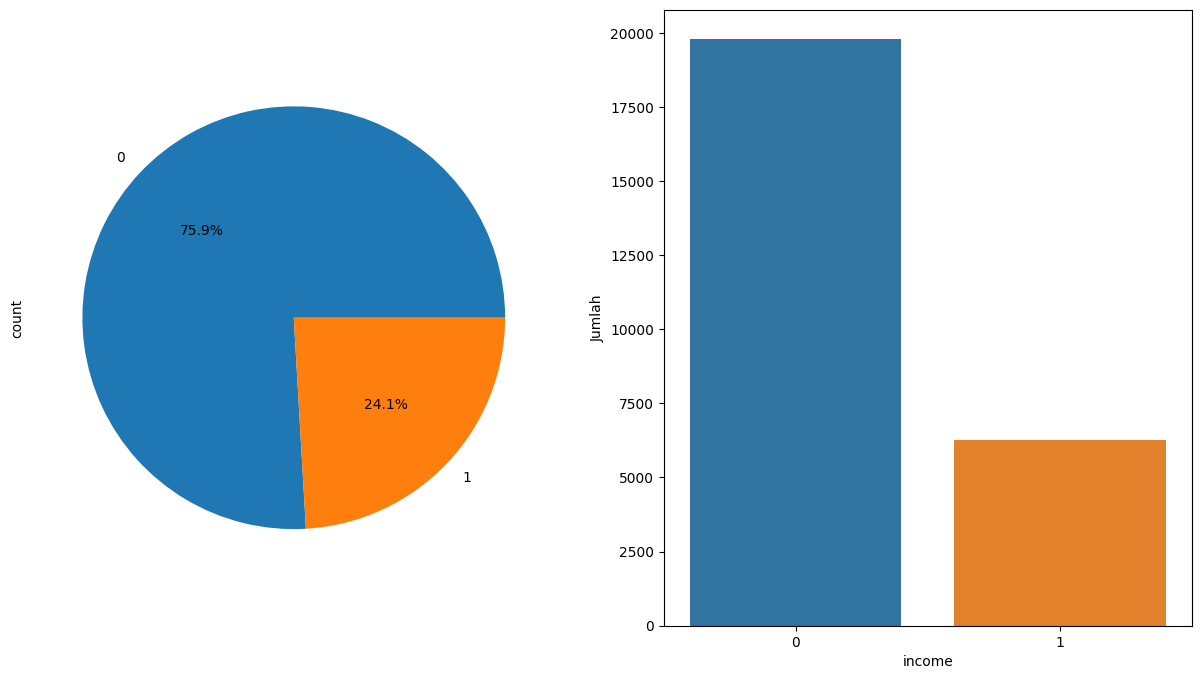

In [32]:
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
train_data['income'].value_counts().plot.pie(autopct='%1.1f%%')
plt.subplot(1,2,2)
sns.countplot(x='income',data=train_data)
plt.ylabel('Jumlah')
train_data['income'].value_counts()

Dari data di atas dapat dikatakan bahwa data sangat tidak seimbang. Ada kurang dari 25% kategori pendapatan >50K sementara lebih dari 75% kategori pendapatan <=50K.

Kelas Pekerjaan
Swasta                      18114
Pengusaha perorangan         2043
Pemerintah daerah            1705
Pemerintah negara            1053
Pengusaha berbadan hukum      894
Pemerintah pusat              766
Tanpa bayaran                  13
Tidak bekerja                   6
Name: count, dtype: int64

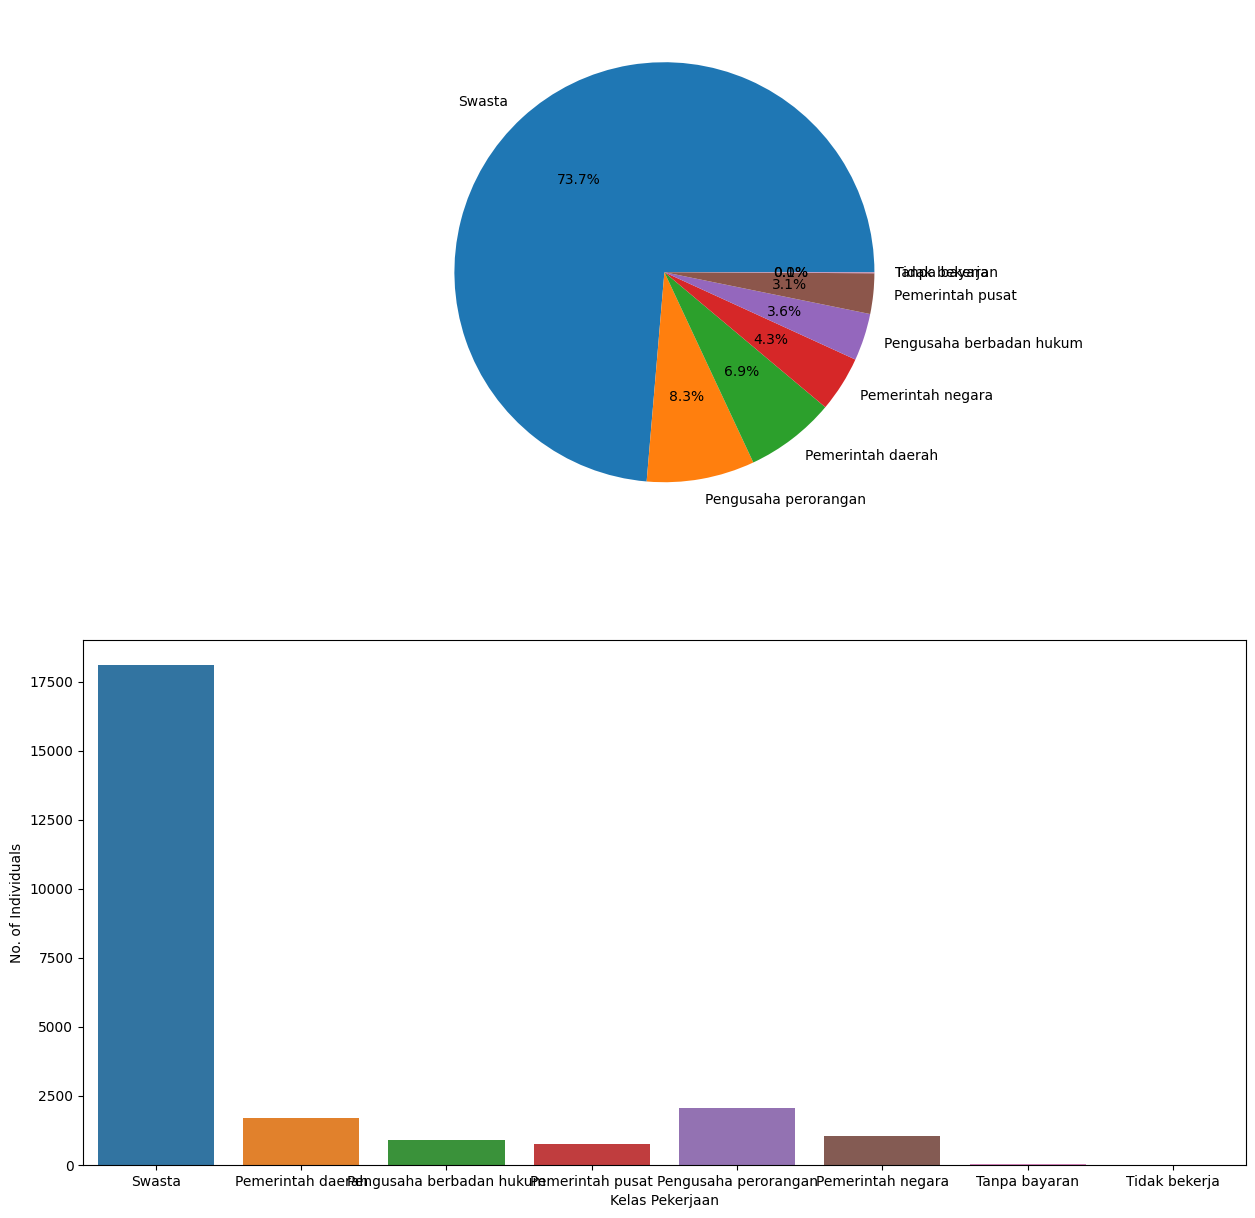

In [33]:
plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
train_data['Kelas Pekerjaan'].value_counts().plot.pie(autopct='%1.1f%%')
plt.ylabel('')
plt.subplot(2,1,2)
sns.countplot(x='Kelas Pekerjaan',data=train_data)
plt.ylabel('No. of Individuals')
train_data['Kelas Pekerjaan'].value_counts()

Total ada 9 kelas pekerja termasuk yang tidak pernah bekerja. Sebagian besar individu bekerja di sektor swasta dan hanya sedikit yang tidak pernah bekerja atau bekerja tanpa upah

Pekerjaan
Spesialis Profesional            3324
Pekerjaan Kerajinan              3303
Eksekutif Manager                3259
Administratif dan Kantor         2953
Sales                            2934
Layanan Lainnya                  2613
Inspeksi dan Operasi Mesin       1610
Transportasi dan Pengangkutan    1277
Pengelola Kebersihan             1120
Pertanian dan Perikanan           793
Dukungan Teknis                   739
Layanan Perlindungan              528
Pembantu Rumah Tangga             129
Angkatan Bersenjata                 6
Name: count, dtype: int64

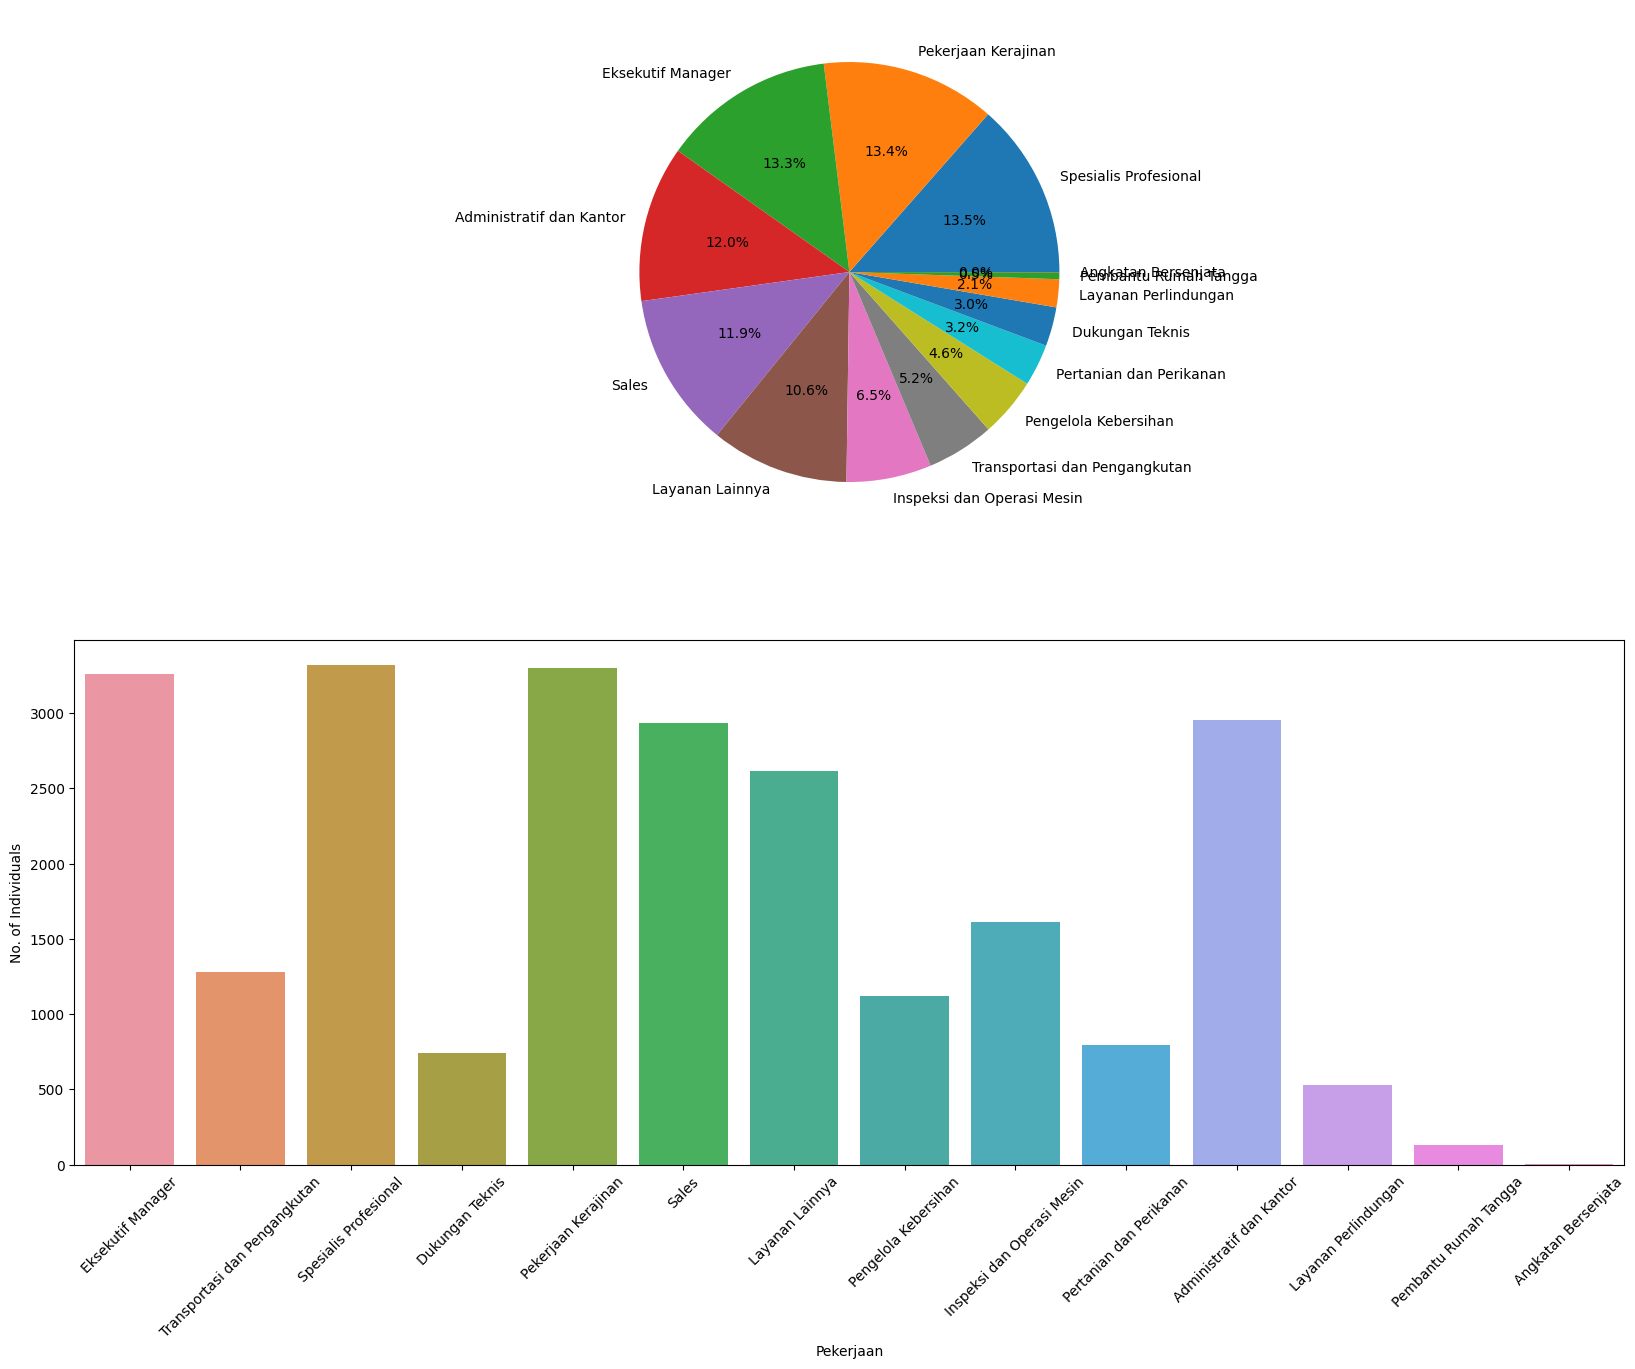

In [34]:
plt.figure(figsize=(20,15))
plt.subplot(2,1,1)
train_data['Pekerjaan'].value_counts().plot.pie(autopct='%1.1f%%')
plt.ylabel('')
plt.subplot(2,1,2)
sns.countplot(x='Pekerjaan',data=train_data)
plt.xticks(rotation=45)
plt.ylabel('No. of Individuals')
train_data['Pekerjaan'].value_counts()

Kita dapat mengamati di sini bahwa Spesialis Profesional memiliki jumlah orang terbanyak dibanding pekerjaan lainnya. Diikuti oleh tukang reparasi kerajinan. Kategori pekerjaan minimum adalah angkatan bersenjata dengan hanya 6 orang di dalamnya.

Asal Negara
United-States                 23355
Mexico                          532
?                               458
Philippines                     157
Germany                         109
Canada                           93
Puerto-Rico                      92
El-Salvador                      85
Cuba                             83
India                            82
England                          69
South                            68
China                            61
Jamaica                          60
Italy                            60
Dominican-Republic               58
Vietnam                          52
Poland                           48
Columbia                         48
Japan                            46
Taiwan                           44
Guatemala                        43
Haiti                            36
Iran                             31
Portugal                         30
France                           27
Greece                           25
Ecuador         

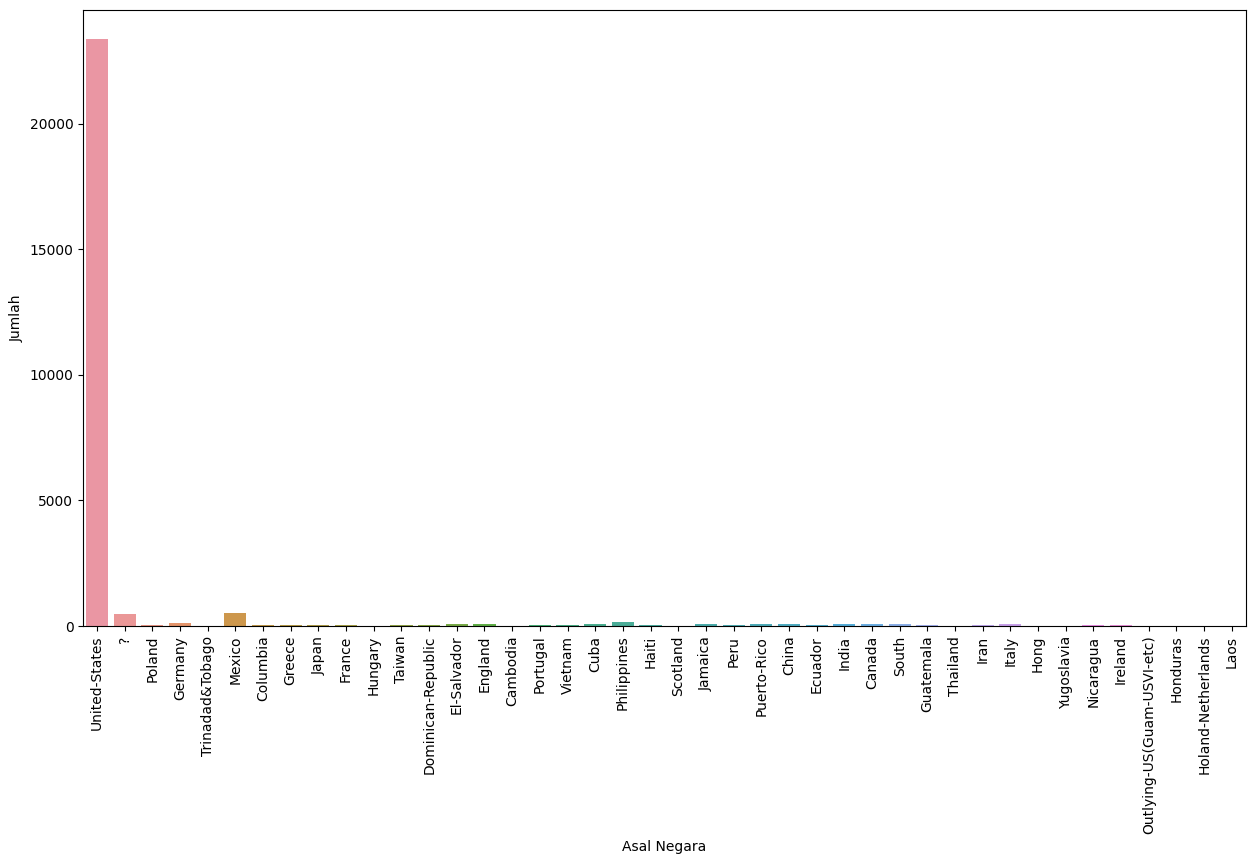

In [36]:
plt.figure(figsize=(15,8))
sns.countplot(x='Asal Negara',data=train_data)
plt.xticks(rotation=90)
plt.ylabel('Jumlah')
train_data['Asal Negara'].value_counts()

Mayoritas pekerja berasal dari AS, sedangkan ada orang yang datang ke AS dari negara asal mereka, tetapi jumlahnya sangat sedikit. Jumlah pekerja terbanyak kedua berasal dari Meksiko karena merupakan negara tetangga.

In [19]:
train_data['income'] = train_data['income'].map(lambda x: 1 if x == '>50K' else 0)

### Data Preprocessing

In [20]:
# Feature engineering
train_data['age'] = 2024 - train_data['Tahun Kelahiran']  # Creating age from 'Tahun Kelahiran'
train_data.drop(columns=['Tahun Kelahiran'], inplace=True)

test_data['age'] = 2024 - test_data['Tahun Kelahiran']  # Creating age from 'Tahun Kelahiran'
test_data.drop(columns=['Tahun Kelahiran'], inplace=True)

Kami mengganti tahun kelahiran agar model lebih mudah untuk membaca data

In [21]:
train_data.head()

,ID,Kelas Pekerjaan,fnlwgt,Pendidikan,Jenjang Pendidikan,Status,Pekerjaan,Hubungan,Etnis,sex,pendapatan,pengeluaran,hours per week,Asal Negara,jumlah_anak,income,age
0,478,Swasta,37210,Sarjana,Sarjana,Menikah,Eksekutif Manager,Suami,1,Male,0,0,45,United-States,2,1,32
1,479,Swasta,101950,Magister,Magister,Belum-menikah,Eksekutif Manager,Tidak dalam Keluarga,1,Female,0,0,45,United-States,0,0,43
2,480,NaN,122244,SMA Grad,SMA Grad,Belum-menikah,NaN,Tidak dalam Keluarga,1,Female,0,0,28,United-States,0,0,20
3,481,Pemerintah daerah,24763,Diploma,Kuliah,Cerai,Transportasi dan Pengangkutan,Belum Menikah,1,Male,6849,0,40,United-States,0,0,40
4,482,Swasta,113936,Sarjana,Sarjana,Belum-menikah,Spesialis Profesional,Punya Anak,1,Male,0,0,40,United-States,0,0,24


In [23]:
# Fitur kategori dan numerik
categorical_columns = ['Kelas Pekerjaan', 'Pendidikan', 'Jenjang Pendidikan', 'Status', 'Pekerjaan', 'Hubungan', 'sex', 'Asal Negara']
numerical_columns = ['age', 'fnlwgt', 'pendapatan', 'pengeluaran', 'hours per week', 'jumlah_anak']

# Preprocessing kategori
categorical_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Isi nilai yang hilang dengan nilai paling sering
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-Hot encoding
])

# Preprocessing numerik
numerical_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Isi nilai yang hilang dengan rata-rata
    ('scaler', 'passthrough')  # Anda bisa menambahkan scaling di sini jika ingin menggunakan model lain yang membutuhkan scaling
])

# Gabungkan preprocessing kategori dan numerik
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_preprocessor, numerical_columns),
        ('cat', categorical_preprocessor, categorical_columns)
    ])

X_train = train_data.drop(columns=['Asal Negara'])
X_test = test_data.copy()
X_test = X_test.drop(columns=['Asal Negara'])

# Pisahkan fitur (X) dan target (y)
X_train = train_data.drop('income', axis=1)
y_train = train_data['income']
X_test = test_data.copy()

# Terapkan preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [24]:
# SMOTE-Tomek to handle class imbalance
X_train_balanced, y_train_balanced = SMOTETomek(random_state=42).fit_resample(X_train_processed, y_train)

Kami menggunakan SMOTE untuk mengatasi data yang tidak seimbang

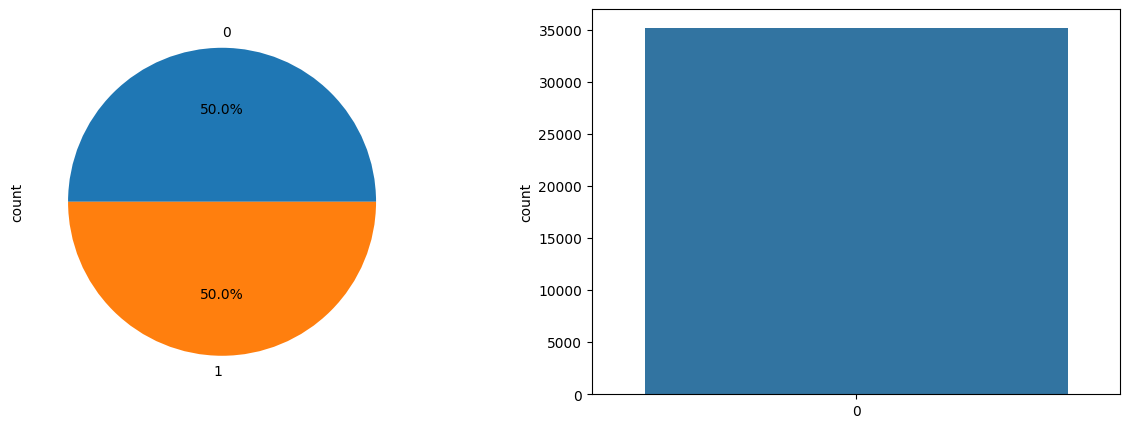

income
0    17596
1    17596
Name: count, dtype: int64

In [37]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
y_train_balanced.value_counts().plot.pie(autopct='%1.1f%%')
plt.subplot(1, 2, 2)
sns.countplot(y_train_balanced)
plt.show()
y_train_balanced.value_counts()

Dapat dilihat dari chart di atas bahwa data telah seimbang

### Hyperparameter Tuning

In [26]:
# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Define parameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200, 300],    # Jumlah pohon yang lebih variatif
    'max_depth': [3, 6, 9],             # Kedalaman yang cukup untuk menangkap pola kompleks tanpa overfitting
    'learning_rate': [0.01, 0.05, 0.1], # Laju pembelajaran dengan nilai moderat untuk stabilitas dan kecepatan
    'subsample': [0.8, 1.0],            # Sampling pada subset data, mengurangi overfitting jika terlalu banyak fitur    
}

# Setup the pipeline with SMOTE-Tomek and XGBoost
xgb_model = xgb.XGBClassifier(eval_metric='mlogloss')

# GridSearchCV with Stratified K-Fold
grid_search = GridSearchCV(estimator=xgb_model,
                           param_grid=param_grid,
                           scoring='f1',
                           cv=skf,
                           verbose=2, 
                           n_jobs=-1)

# Fit model with GridSearchCV
grid_search.fit(X_train_balanced, y_train_balanced)

# Tampilkan parameter terbaik
print("Best parameters found: ", grid_search.best_params_)

# Get the best model
best_xgb_model = grid_search.best_estimator_

Fitting 10 folds for each of 54 candidates, totalling 540 fits
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   2.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.7s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.7s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.7s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.6s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.6s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.7s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.6s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.7s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.

### Data Test Prediction

In [27]:
# Predict on test data with best model
y_test_proba = best_xgb_model.predict_proba(X_test_processed)[:, 1]

# Apply threshold tuning as before
precision, recall, thresholds = precision_recall_curve(y_train_balanced, best_xgb_model.predict_proba(X_train_balanced)[:, 1])
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[f1_scores.argmax()]
print("Best Threshold:", best_threshold)

# Predict on test data using best threshold
y_test_pred = (y_test_proba >= best_threshold).astype(int)

Best Threshold: 0.440628


### Save Prediction

In [28]:
# Create submission file
submission = pd.DataFrame({'ID': test_data['ID'], 'income': y_test_pred})
submission.to_csv('submission.csv', index=False)